# Week 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import edhec_risk_kit as erk

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Modern portfolio theory (MPT)

The **Modern portfolio theory (MPT)** is a mathematical framework **for assembling a portfolio of assets such that the expected return is maximized for a given level of volatility**. It is a formalization of **diversification in investing**, i.e., the idea that owning different kinds of financial assets is less risky than owning only one type. 

### Efficient Frontiers 

In the MPT, The **efficient frontier** is an a curve which occupies the *efficient* part of the **volatility-return** plane. 
Formally, it is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected 
return but with the same standard deviation of return. 

The efficient frontier was first formulated by **Harry Markowitz** (1952).

### How it works
We have to construct a portfolio of several assets and **we want to find the optimal percentages of investment to be allocated in these assets** so that the overall (expected) return of such a portfolio is maximixed for a given level of volatility. 

Hence, suppose that **we have $N > 1$ assets**, and we decide to invest all of our capital in these assets. 

Let $\mathbf{w}:=(w_1,\dots,w_N)^T$, with $w_i\in (0,1)$ for all $i=1,\dots,N$, 
be the percentages of investment our portfolio, i.e., $w_i$ is the proportion of investiment in asset $i$. 
We will call the quantities $w_i$ as the **weights**. 

There holds $\sum_{i=1}^N w_i = 1$. 

Let $R_i$ and $R_p$ be the return of asset $i$ and the total return of the portfolio, respectively. 
Likewise, let $\sigma_i$ and $\sigma_p$ be the volatility of asset $i$ and the volatility of the portfolio, respectively. 


### Return of a portfolio
The **total return of the porfolio** is going to be a simple weigthed sum of the (total) returns of single assets, i.e.,
$$
R_p = \sum_{i=1}^N w_i R_i = \mathbf{w}^T \mathbf{R},
$$
where $\mathbf{R} := (R_1,\dots,R_N)^T$.


### Volatility of a portfolio
The **volatility of the porfolio** is computed as the (square root of the) variance of the weigthed sum of the returns of single assets. 

Let us make and axample with only two assets. We have $w_1$ and $w_2$ and two assets whose returns are $R_1$ and $R_2$. We have:
$$
\sigma_p^2 =   \text{Var}(w_1 R_1 + w_2 R_2) = 
w_1^2 \text{Var}(R_1) + w_2^2\text{Var}(R_2) + 2w_1 w_2\text{Cov}(R_1,R_2) =
w_1^2 \sigma_1^2 + w_2^2\sigma_2^2 + 2w_1 w_2\text{Cov}(R_1,R_2), 
$$
where 
$$
\text{Cov}(R_1,R_2) := \mathbb{E}[(R_i-\mu_i)(R_j - \mu_j)], 
$$
is the **covariance** between asset $i$ and $j$ and where $\mu_i$ and $\mu_j$ denote 
the mean returns of assets $i$ and $j$, respectively. In particular, if we let 
$$
\rho_{ij} := \frac{\text{Cov}(R_i,R_j)}{\sigma_i \sigma_j} = \frac{\text{Cov}(i,j)}{\sigma_1 \sigma_2}, 
$$
denote the **correlation coefficient** between assets $i$ and asset $j$, then the volatility of a $2$ assets portfolio becomes:
$$
\sigma_p = 
\sqrt{ w_i^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \sigma_1 \sigma_2 \rho_{ij} }. 
$$
Note that we can write in compact form the such volatility using matrix notation. That is:
$$
\sigma_p = 
\sqrt{
(w_i, w_2)\, 
\begin{pmatrix}
\sigma^2_1 & \sigma_1 \sigma_2 \rho_{12} \\
\sigma_1 \sigma_2 \rho_{21} & \sigma^2_2
\end{pmatrix}
\begin{pmatrix}
w_1 \\
w_2 
\end{pmatrix}
}
=
\sqrt{
\mathbf{w}^T \Sigma \mathbf{w}
}
\quad\text{and}\quad
\Sigma := 
\begin{pmatrix}
\sigma^2_1 & \sigma_1 \sigma_2 \rho_{12} \\
\sigma_1 \sigma_2 \rho_{21} & \sigma^2_2
\end{pmatrix},
$$
where $\Sigma$ is the symmetric square **covariance matrix**.


Now, in case of $N$ assets, let again $\Sigma$ be the $N\times N$ covariance matrix, $\Sigma = [c_{ij}]$, 
where each element $c_{ij} := \sigma_i \sigma_j \rho_{ij}$ ($i,j=1,\dots,N$) denote the **covariance** between assets $i$ 
and asset $j$, with $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ being the volatility 
and the correlation coefficient of assets $i$ and $j$, respectively. 
If $i=j$, $c_{ii}=\sigma_i^2$ is simply the variance of asset $i$ (**diagonal entries are the variances**).

The volatility of the portfolio is then given by:
$$
\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }.
$$


### Efficient frontiers of 2-assets portfolios 
In the following, we propose an artificial example in order to see the curve that is drawn by different portfolios which 
are constructed with only $2$ assets with different correlation $\rho_{12}$. 
First of all, we assume to generate $500$ daily returns of $2$ assets:

In [5]:
nret             = 500
periods_per_year = 252
risk_free_rate   = 0.0

Then, we set up a value for the means and the volatility of our two artifical assets:

In [6]:
mean_1 = 0.001019
mean_2 = 0.001249
vol_1  = 0.016317
vol_2  = 0.019129

and we set up the $6$ correlations of the two assets, and for every fixed correlation, 
we will generate $20$ portfolios by allocating $20$ pairs of weights:

In [7]:
# Correlation goes from 1 (completely correlated) to -1 (conversely correlated)
rhos  = np.linspace(1,-1,num=6) 
ncorr = len(rhos)

# Pairs of weights to be used to construct the portfolios for any given correlation
nweig = 20
w1 = np.linspace(0,1,num=nweig)
w2 = 1 - np.linspace(0,1,num=nweig)
ww = pd.DataFrame( [w1, w2] ).T  

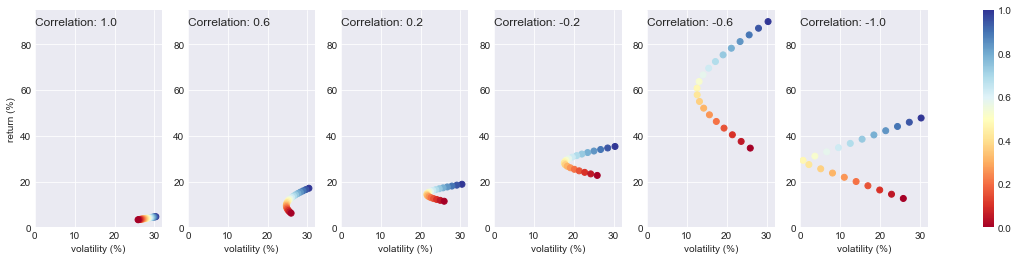

In [8]:
# Set seed
np.random.seed(1)

# Open the figure
fig, ax = plt.subplots(1,6, figsize=(20,4))    
ax = ax.flatten()

for k_rho, rho in enumerate(rhos):
    # Allocate an empty portfolio 
    portfolio = pd.DataFrame(columns=["return","volatility","sharpe ratio"])

    # Generate the assets' returns with the given correlation rho
    cov_ij     = rho * vol_1 * vol_2
    cov_rets   = pd.DataFrame( [[vol_1**2, cov_ij], [cov_ij, vol_2**2]] )
    daily_rets = pd.DataFrame( np.random.multivariate_normal((mean_1,mean_2), cov_rets.values, nret) )
    
    for i in range(ww.shape[0]):
        # Now, construct the portfolio of two asset with correlation rho and weights ww.loc[i]
        weights = ww.loc[i] 
        # here, weights is a column vector (pd.Series)

        # annualized portfolio returns
        ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
        portfolio_ret = erk.portfolio_return(weights, ann_rets)        

        # annualized portfolio volatility
        portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
        portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

        # annualized portfolio sharpe ratio
        portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)

        # dataframe containing the return, volatility, and the sharpe ratio of the portfolio constructed   
        portfolio = portfolio.append( {"return":portfolio_ret, "volatility": portfolio_vol, "sharpe ratio":portfolio_spr}, ignore_index=True)

    # plot create scatter plot coloured by Sharpe Ratio
    im = ax[k_rho].scatter(portfolio["volatility"]*100, portfolio["return"]*100, c=w2, cmap='RdYlBu') 
    ax[k_rho].grid()
    ax[k_rho].set_title("Correlation: {}".format(np.round(rho,2)), y=0.9, loc='left')
    ax[k_rho].set_xlabel("volatility (%)")
    if k_rho==0: ax[k_rho].set_ylabel("return (%)") 
    ax[k_rho].set_xlim([0,32])
    ax[k_rho].set_ylim([0,95])
    
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

For any given correlation, each point represents the pair (return, volatility) of a portfolio constructed with some percentage allocation. 
This can be seen in the colorbar: **red corresponds to $\mathbf{w} = (1,0)$**, i.e., allocation of money only to the first asset, whereas 
**blue corresponds to $\mathbf{w} = (0,1)$**, i.e., allocation of money only ot the second asset.  

We can see that **the lower the correlation between the assets, the better the trade-off between return and volatility**: in this example, 
when $\rho=-1$, we could in principle construct a portfolio which guarantee about $30\%$ of return with almost no volatility.

### Example from the real world: US stocks
Now we will get the timeseries of some US economy stocks and see how to construct a portfolio in an efficient way.

In [9]:
tickers  = ['AMZN','KO','MSFT']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=datetime(2010,1,1), end=datetime(2019,11,15))["Adj Close"]    

In [10]:
stocks.tail()

,AMZN,KO,MSFT
Date,,,
2019-11-11,1771.650024,51.840000,146.110001
2019-11-12,1778.000000,51.709999,147.070007
2019-11-13,1753.109985,52.410000,147.309998
2019-11-14,1754.599976,52.630001,148.059998
2019-11-15,1739.489990,52.669998,149.970001


In [11]:
# compute the daily returns 
daily_rets = erk.compute_returns(stocks)
daily_rets.tail()

,AMZN,KO,MSFT
Date,,,
2019-11-11,-0.007968,-0.007087,0.001028
2019-11-12,0.003584,-0.002508,0.006570
2019-11-13,-0.013999,0.013537,0.001632
2019-11-14,0.000850,0.004198,0.005091
2019-11-15,-0.008612,0.000760,0.012900


In [12]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

,AMZN,KO,MSFT
AMZN,0.000384,0.000047,0.000138
KO,0.000047,0.000088,0.000050
MSFT,0.000138,0.000050,0.000207


Now we simulate $4000$ portfolios with weights allocated to the stocks above:

In [13]:
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility","sharpe ratio","w1","w2","w3"])
risk_free_rate   = 0

In [14]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = erk.portfolio_return(weights, ann_rets)        

    # annualized portfolio volatility
    portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
    portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

    # annualized portfolio sharpe ratio
    portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)
    
    # create dataframe   
    portfolios = portfolios.append( {"return":portfolio_ret, 
                                     "volatility":portfolio_vol, 
                                     "sharpe ratio":portfolio_spr, 
                                     "w1": weights[0], "w2": weights[1], "w3": weights[2]}, 
                                     ignore_index=True)

Now we create a scatter plot coloured by sharpe ratios of the portfolios generated above and we also plot the efficient frontier 

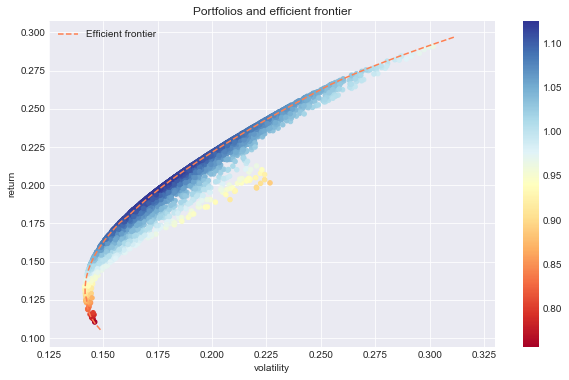

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.set_xlim([0.125,0.33])

fig.colorbar(im, ax=ax)
plt.show()

**We will come back to the plot of the efficient frontier below**.

We can see that if the investor is targeting **a return of $20\%$** he could simply hold 
a portfolio **with volatility of about $17.5\%$**, although there are many other portfolios that 
can guarantee the same return but with much higher volatilities such as $22.5\%$. 
It is clear that one should carefully choose the weights of the portfolio. 

We can see, in particular, that there are two *important* portfolios:

1. the **portfolio with the lowest volatility**, i.e., the minimum variance portfolio
2. the **portfolio with the highest sharpe ratio**.

From the code above we can easily locate these two portfolios in our dataframe by looking at the lowest volatility and highest sharpe ratio 
and and recover the corresponding weights that have been stored.

In [16]:
# find the portfolio with lowest volatility 
low_vol_portfolio = portfolios.iloc[ portfolios['volatility'].idxmin() ]
print("Minimum volatility portfolio:")
print("- return      : {:.2f}%".format(low_vol_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(low_vol_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(low_vol_portfolio[2]) )

# find the portfolio with highest sharpe ratio
high_sharpe_portfolio = portfolios.iloc[ portfolios['sharpe ratio'].idxmax() ]
print("\nHighest sharpe ratio portfolio:")
print("- return      : {:.2f}%".format(high_sharpe_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(high_sharpe_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(high_sharpe_portfolio[2]) )

Minimum volatility portfolio:
- return      : 13.11%
- volatility  : 14.17%
- sharpe ratio: 0.93

Highest sharpe ratio portfolio:
- return      : 19.39%
- volatility  : 17.24%
- sharpe ratio: 1.13


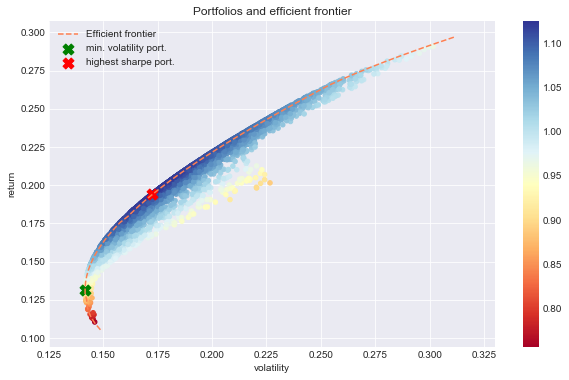

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, label=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(low_vol_portfolio[1],     low_vol_portfolio[0],     marker="X", color='g', s=120, label="min. volatility port.")
ax.scatter(high_sharpe_portfolio[1], high_sharpe_portfolio[0], marker="X", color='r', s=120, label="highest sharpe port.")

ax.set_xlim([0.125,0.33])
ax.legend()

fig.colorbar(im, ax=ax)
plt.show()

Let us define the following function which we are going to use several time in what follows:

In [26]:
def get_portfolio_features(weights, rets, covmat, risk_free_rate, periods_per_year):
    # portfolio volatility
    vol = erk.portfolio_volatility(weights, covmat)
    vol = erk.annualize_vol(vol, periods_per_year)

    # portfolio return
    ret = erk.portfolio_return(weights, rets)

    # portfolio sharpe ratio
    shp = erk.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)

    print("Portfolio return:       {:.2f}%" .format(ret*100))
    print("Portfolio volatility:   {:.2f}%" .format(vol*100))
    print("Portfolio sharpe ratio: {:.2f}" .format(shp))
    
    return ret, vol, shp

### Finding the optimal portfolios: minimizing the volatility 

In the experiments above, we found the optimal portfolios, i.e., the ones on the efficient frontier, by **simulating a high number of portfolios** and then plotting them. From the plot we could see what the efficient frontier looked like. 
However, we can find an optimal portfolio on the efficient frontier by **solving a minimization problem**, 
for example, by applying the **scipy optimize** method. 


For example, suppose we want to **find the portfolio (on the efficient frontier) which has the minimum volatility**. 
Then the minimization problem is:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

In [19]:
# Let us see the total (annual) returns of single companies we are investing in
ann_rets = erk.annualize_rets(daily_rets, periods_per_year)
ann_rets

AMZN    0.296842
KO      0.105357
MSFT    0.201881
dtype: float64

Now, we can call our minimizer which solves the minimization problem of finding the weights of the portfolio with minimum volatility. 

In [143]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 5.57%
  KO:   78.98%
  MSFT: 15.45%


Let us compute the volatility of the portfolio constructed with these weights and locate it on the efficient frontier:

Portfolio return:       13.09%
Portfolio volatility:   14.17%
Portfolio sharpe ratio: 0.92


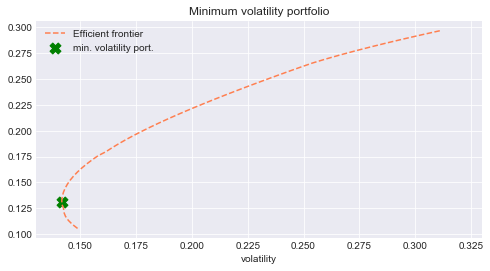

In [27]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='g', s=120, label="min. volatility port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Minimum volatility portfolio")
plt.show()

We can also verify that the minimum volatility portfolio obtained by solving the minimization problem almost coincides 
with the one obtained from simulating a high number of portfolios as we have done before: 

In [28]:
print("Minimum volatility portfolio:")
print("- Monte carlo:")
print("  return:       {:.2f}%" .format(low_vol_portfolio[0]*100))
print("  volatility:   {:.2f}%" .format(low_vol_portfolio[1]*100))
print("  sharpe ratio: {:.2f}" .format(low_vol_portfolio[2]))
print("\n- Minimization problem:")
print("  return:       {:.2f}%" .format(ret*100))
print("  volatility:   {:.2f}%" .format(vol*100))
print("  sharpe ratio: {:.2f}" .format(shp))

Minimum volatility portfolio:
- Monte carlo:
  return:       13.11%
  volatility:   14.17%
  sharpe ratio: 0.93

- Minimization problem:
  return:       13.09%
  volatility:   14.17%
  sharpe ratio: 0.92


#### Finding the optimal portfolios: minimizing the volatility given a fixed return

What if we want to find the **portfolio (on the efficient frontier) with minimium volatility for a given a level of return**? 
In this case, we simply have to add a constrain in the minimization problem:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$
where $R_0$ denotes a fixed level of expected return. For example, suppose we target the following total expected return $R_0=16\%$:

In [30]:
target_return = 0.16

Now, we can call again the minimizer with the option of solving the problem with the constrain for the given target return:

In [32]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets, target_return)
print("optimal weights: {}".format(optimal_weights))

optimal weights: [0.17721337 0.60823559 0.21455104]


Let us compute the volatility of the portfolio constructed with these weights. 
Also, we double check that the corresponding return is the target return that we have chosen (i.e., $16\%$) and 
locate the portfolio on the efficient frontier:

Portfolio return:       16.00%
Portfolio volatility:   14.87%
Portfolio sharpe ratio: 1.08


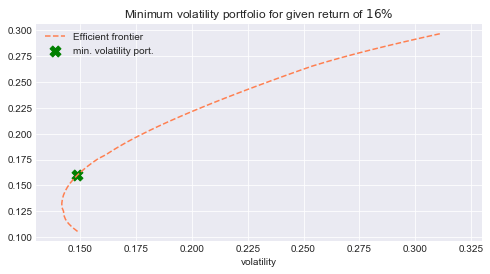

In [32]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, target_return,  marker="X", color='g', s=120, label="min. volatility port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Minimum volatility portfolio for given return of $16\%$")
plt.show()

Recall that **the return of a portfolio will be some value between the minimum and the maximum return from the assets composing the portfolio**. That is, given the same three companies, we cannot achieve a return of, say $40\%$ since the maximum return achievable is about $30\%$ from Amazon. 
In fact, if we run the minimizer with a target return equal to $40\%$ we will get zero weights to all assets but Amazon:

In [33]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets, 0.4)
print(optimal_weights)

[1.00000000e+00 0.00000000e+00 3.74159232e-13]


### Finding the optimal portfolios: maximizing the sharpe ratio 

Now, consider the case of finding **the portfolio (on the efficient frontier) with the highest sharpe ratio**. 

Note that scipy offers a **minimize** method, but no a **maximize** a method, and we may then conclude 
that we are not able to find such a portfolio by solving an optimization problem. 
However, **the maximization of the sharpe ratio is nothing but the minimization of the negative sharpe ratio**. 
That is, we have 
$$
\text{minimize} \;\; -  \frac{R_p - r_f}{\sigma_p} =: \text{SR} 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

Let us use our minimizer:

In [34]:
optimal_weights = erk.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
print("optimal weights: {}".format(optimal_weights))

optimal weights: [0.31920934 0.39606811 0.28472255]


Portfolio return:       19.40%
Portfolio volatility:   17.24%
Portfolio sharpe ratio: 1.13


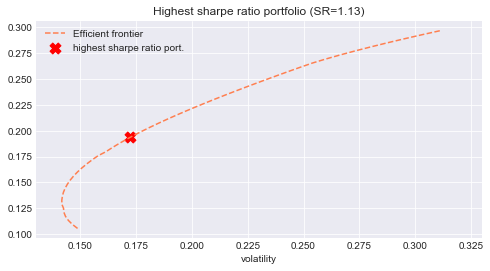

In [36]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='r', s=120, label="highest sharpe ratio port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Highest sharpe ratio portfolio (SR={:.2f})".format(shp))
plt.show()

and let us see how these numbers differ from those obtained from the Monte Carlo simulation:

In [37]:
print("Minimum volatility portfolio:")
print("- Monte carlo:")
print("  return:       {:.2f}%" .format(high_sharpe_portfolio[0]*100))
print("  volatility:   {:.2f}%" .format(high_sharpe_portfolio[1]*100))
print("  sharpe ratio: {:.2f}" .format(high_sharpe_portfolio[2]))
print("\n- Minimization problem:")
print("  return:       {:.2f}%" .format(ret*100))
print("  volatility:   {:.2f}%" .format(vol*100))
print("  sharpe ratio: {:.2f}" .format(shp))

Minimum volatility portfolio:
- Monte carlo:
  return:       19.39%
  volatility:   17.24%
  sharpe ratio: 1.13

- Minimization problem:
  return:       19.40%
  volatility:   17.24%
  sharpe ratio: 1.13


#### Finding the optimal portfolios: maximize the sharpe ratio given a fixed volatility 

Similarly to what we have done before, we can find the **portfolio (on the efficient frontier) with highest sharpe ratio 
for a given a level of volatility**. In this case, we simply add a constrain in the minimization problem:
$$
\text{minimize} \;\; -  \frac{R_p - r_f}{\sigma_p} =: \text{SR} 
$$
subject to 
$$
\begin{cases}
\frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} = \sigma_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$
where $\sigma_0$ denotes a fixed level of volatility. For example, suppose we target the following total volatility of $\sigma_0=20\%$:

In [38]:
target_volatility = 0.2
optimal_weights = erk.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year, target_volatility)
print("optimal weights: {}".format(optimal_weights))

optimal weights: [0.43529676 0.22468694 0.3400163 ]


Portfolio return:       22.15%
Portfolio volatility:   20.00%
Portfolio sharpe ratio: 1.11


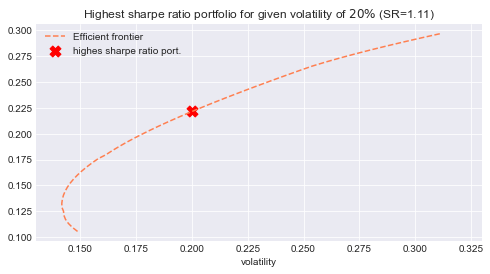

In [40]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='r', s=120, label="highes sharpe ratio port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Highest sharpe ratio portfolio for given volatility of $20\%$ (SR={:.2f})".format(shp))
plt.show()

### Observation on constraints

It is worth mentioning that so far we have decided to invest all of our capital and, at the same time, our strategy has been **long-only**. That is, the weights that we allocate to the assets sum to $1$ 
and all of them are positive (because we **buy** the assets). 
In particular, these two conditions were imposed when solving the minimization problems. 

However, **we could in principle not invest all of our capital**, which means that we at do not necessarily 
get weights that sum to $1$, and also we may decide to not buy all the assets. We could **short selling** some of them (by short shelling we mean selling an asset that we do not have and that we borrow from someone else).

#### Finding minimum portofolio volatility for a given fixed return 

We can solve the minimization problem without imposing the constraint on positive weigths and the constraint that the weights sum to $1$, i.e., simply:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, 
\end{cases}
$$
in the case of finding the minimum volatility portfolio for a fixed return. 

For such a problem we can find the analytical solution to the problem by using the **Lagrange multipliers**. We define the **Lagrangian** of the problem:
$$
\mathcal{L}(\mathbf{w}, \lambda) := \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} - \lambda(  \mathbf{w}^T \mathbf{R} - R_0 ),
$$
and put the partial derivatives to zero:
$$
\begin{cases}
\frac{\partial\mathcal{L}}{\partial \mathbf{w}} &= \frac{1}{2} (2\Sigma \mathbf{w}) - \lambda  \mathbf{R} = 0, \\
\frac{\partial\mathcal{L}}{\partial \lambda} &=  \mathbf{w}^T \mathbf{R} - R_0 = 0.
\end{cases}
$$
From the first equation, we get:
$$
\Sigma \mathbf{w} - \lambda  \mathbf{R} = 0 
\quad\Longrightarrow\quad 
\mathbf{w} = \lambda \Sigma^{-1}\mathbf{R},  
$$
and inserting in the second equation:
$$
( \lambda \Sigma^{-1}\mathbf{R} )^T \mathbf{R} - R_0 = 0 
\quad\Longrightarrow\quad 
\lambda \mathbf{R}^T \Sigma^{-1} \mathbf{R} = R_0
\quad\Longrightarrow\quad 
\lambda = \frac{R_0}{\mathbf{R}^T \Sigma^{-1} \mathbf{R}},
$$
where notice that since $\Sigma$ was symmetric, so is $\Sigma^{-1}$, from which $(\Sigma^{-1})^T = \Sigma^{-1}$. 
We can then insert $\lambda$ back into the first equation and obtain:
$$
\mathbf{w} = R_0 \frac{\Sigma^{-1}\mathbf{R}}{\mathbf{R}^T \Sigma^{-1} \mathbf{R}},
$$
which is therefore the analytical expression for the weights. Notice that since we have not imposed the constraint 
on the normalisation, we are not guaranteed that such vector of weights sum to $1$.

### Maximizing the sharpe ratio portfolio in presence of non null risk-free rate

Recall that a **risk-free asset** is an (hypothetical) asset with a risk-free rate. For example, **short-term government securities (such as US treasury bills)** are used as a risk-free asset since **they pay a fixed rate of interest and have exceptionally low default risk**. 

The risk-free asset has zero volatility (i.e., is risk free). Furthermore, it is also uncorrelated with any other asset since, 
by definition, its volatility is zero. Therefore, when combined with any other asset in a portfolio, 
**the change in return is linearly related to the change in risk** as the proportions in the combination vary.

#### The capital market line (CML)

When a risk-free asset is introduced, there will be a line satisfying:

 1. it is tangent to the curve at the risky portfolio with the highest Sharpe ratio; 
 2. its vertical intercept represents a portfolio with $100\%$ of holdings in the risk-free asset; 
 3. the tangency with the curve represents the highest shrpe ratio portfolio with no risk-free holdings and $100%$ of risky assets; 
 assets held in the portfolio occurring at the tangency point; 
 4. points on this line represent portfolios containing positive amounts of both the risky assets and the risk-free asset; 
 
This efficient line is called the **Capital Market Line (CML)**, and its given by:
$$
R_{CML} = R_{f} + \sigma_{CML}\frac{R_{p} - R_{f}}{\sigma_{p}}, 
$$
where $R_p$ and $\sigma_p$ are the return and the volatility of the risky portfolio with no risk free asset, respectively, 
$R_f$ denotes the rik-free rate, and $R_{CML}$ and $\sigma_{CML}$ denote the portfolio combining both risky assets and the risk-free asset, respectively.

In [68]:
risk_free_rate = 0.06
optimal_weights = erk.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
print("optimal weights: {}".format(optimal_weights))

optimal weights: [0.5689615  0.09139851 0.33963999]


In [69]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

Portfolio return:       0.24942824315491863
Portfolio volatility:   0.23049907116979854
Portfolio sharpe ratio: 0.8218178155493527


Let us plot the efficient frontier and the capital market line using the optional argument in our plot method:

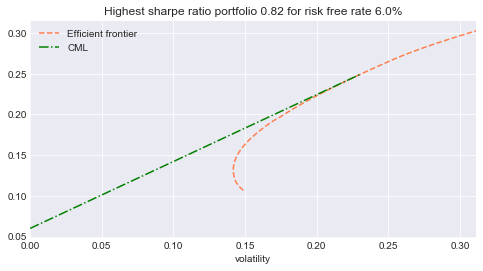

In [70]:
df, ax = erk.efficient_frontier(40, daily_rets, cov_rets, periods_per_year, risk_free_rate=risk_free_rate, 
                                iplot=True, cml=True)
ax.set_title("Highest sharpe ratio portfolio {} for risk free rate {}%".format(np.round(shp,2),risk_free_rate*100))
plt.show()

The introduction of the risk-free asset as a possible component of the portfolio has improved the range of volatility-return combinations available since **everywhere, except at the tangency portfolio, the CML provides a higher return than the (old) efficient frontier does 
at every possible volatility.** 

Note that the efficient frontier method has other optional parameter to plot the highest sharpe ratio, the minimum volatility, and the equally weigthed portfolio as well:

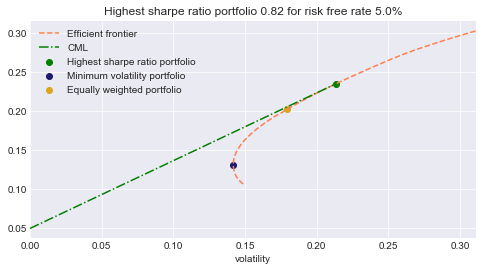

In [71]:
risk_free_rate = 0.05
df, ax = erk.efficient_frontier(40, daily_rets, cov_rets, periods_per_year, risk_free_rate=risk_free_rate, 
                                iplot=True, hsr=True, cml=True, mvp=True, ewp=True)
ax.set_title("Highest sharpe ratio portfolio {} for risk free rate {}%".format(np.round(shp,2),risk_free_rate*100))
plt.show()